# Calculating Final Metrics

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import lpips
import plotly.express as px
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import save_image



from dataset import LTTDataset, load_data_from_dir
from latent_to_timestep_model import Delta_LTT_model, LTT_model
from models import prepare_stuff
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import (
    adjust_hyper,
    get_solvers,
    move_tensor_to_device,
    parse_arguments,
    set_seed_everything,
    visual
)

sns.set_context("paper", font_scale=1.5)
sns.set_style("ticks")

sys.path.append('../')  # Act as if we are one directory higher so imports work
img_save_dir = 'graphics/'


In [2]:



args = parse_arguments([
    "--all_config", "configs/cifar10.yml",
    "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
    "--num_train", "1000",
    "--num_valid", "1000",
    "--main_train_batch_size", "200",
    "--main_valid_batch_size", "200",
    "--training_rounds_v1", "1",
    "--log_path", "logs/logs_cifar10",
    "--force_train", "True",
    "--steps", "5",
    "--lr_time_1", "0.00005",
    "--mlp_dropout", "0.0",
    "--log_suffix", "BiggerValidation_GroupNorm_EvalTrue"
])

set_seed_everything(args.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Dataset
data_dir = 'train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0'
model_dir = "runs_delta_timesteps/models"
steps = 5
lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)


wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)

order = args.order  

def custom_collate_fn(batch):
    collated_batch = []
    for samples in zip(*batch):
        if any(item is None for item in samples):
            collated_batch.append(None)
        else:
            collated_batch.append(torch.utils.data._utils.collate.default_collate(samples))
    return collated_batch

valid_dataset = LTTDataset(dir=os.path.join(data_dir, "validation"), size=args.num_valid, train_flag=False, use_optimal_params=False) 
train_dataset = LTTDataset(dir=os.path.join(data_dir, "train"), size=args.num_train, train_flag=True, use_optimal_params=False)

delta_ltt_model = Delta_LTT_model(steps = steps, mlp_dropout=args.mlp_dropout)
delta_ltt_model = delta_ltt_model.to(device)

wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
solver, steps, solver_extra_params = get_solvers(
    args.solver_name,
    NFEs=args.steps,
    order=args.order,
    noise_schedule=noise_schedule,
    unipc_variant=args.unipc_variant,
)
training_config = TrainingConfig(
    train_data=train_dataset,
    valid_data=valid_dataset,
    train_batch_size=args.main_train_batch_size,
    valid_batch_size=args.main_valid_batch_size,
    lr_time_1=args.lr_time_1,
    shift_lr=args.shift_lr,
    shift_lr_decay=args.shift_lr_decay,
    min_lr_time_1=args.min_lr_time_1,
    win_rate=args.win_rate,
    patient=args.patient,
    lr_time_decay=args.lr_time_decay,
    momentum_time_1=args.momentum_time_1,
    weight_decay_time_1=args.weight_decay_time_1,
    loss_type=args.loss_type,
    visualize=args.visualize,
    no_v1=args.no_v1,
    prior_timesteps=args.gits_ts,
    match_prior=args.match_prior,
)
model_config = ModelConfig(
    net=wrapped_model,
    decoding_fn=decoding_fn,
    noise_schedule=noise_schedule,
    solver=solver,
    solver_name=args.solver_name,
    order=args.order,
    steps=steps,
    prior_bound=args.prior_bound,
    resolution=latent_resolution,
    channels=latent_channel,
    time_mode=args.time_mode,
    solver_extra_params=solver_extra_params,
    device=device,
)
trainer = LD3Trainer(model_config, training_config)


dis_model = DiscretizeModelWrapper( #Changed through LTT
        lambda_max=trainer.lambda_max,
        lambda_min=trainer.lambda_min,
        noise_schedule=trainer.noise_schedule,
        time_mode = trainer.time_mode,
    )


img, latent, _ = valid_dataset[0]
latent = latent.to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /netpool/homes/connor/anaconda3/envs/ld3/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


## Visualize all outputs compared to one another

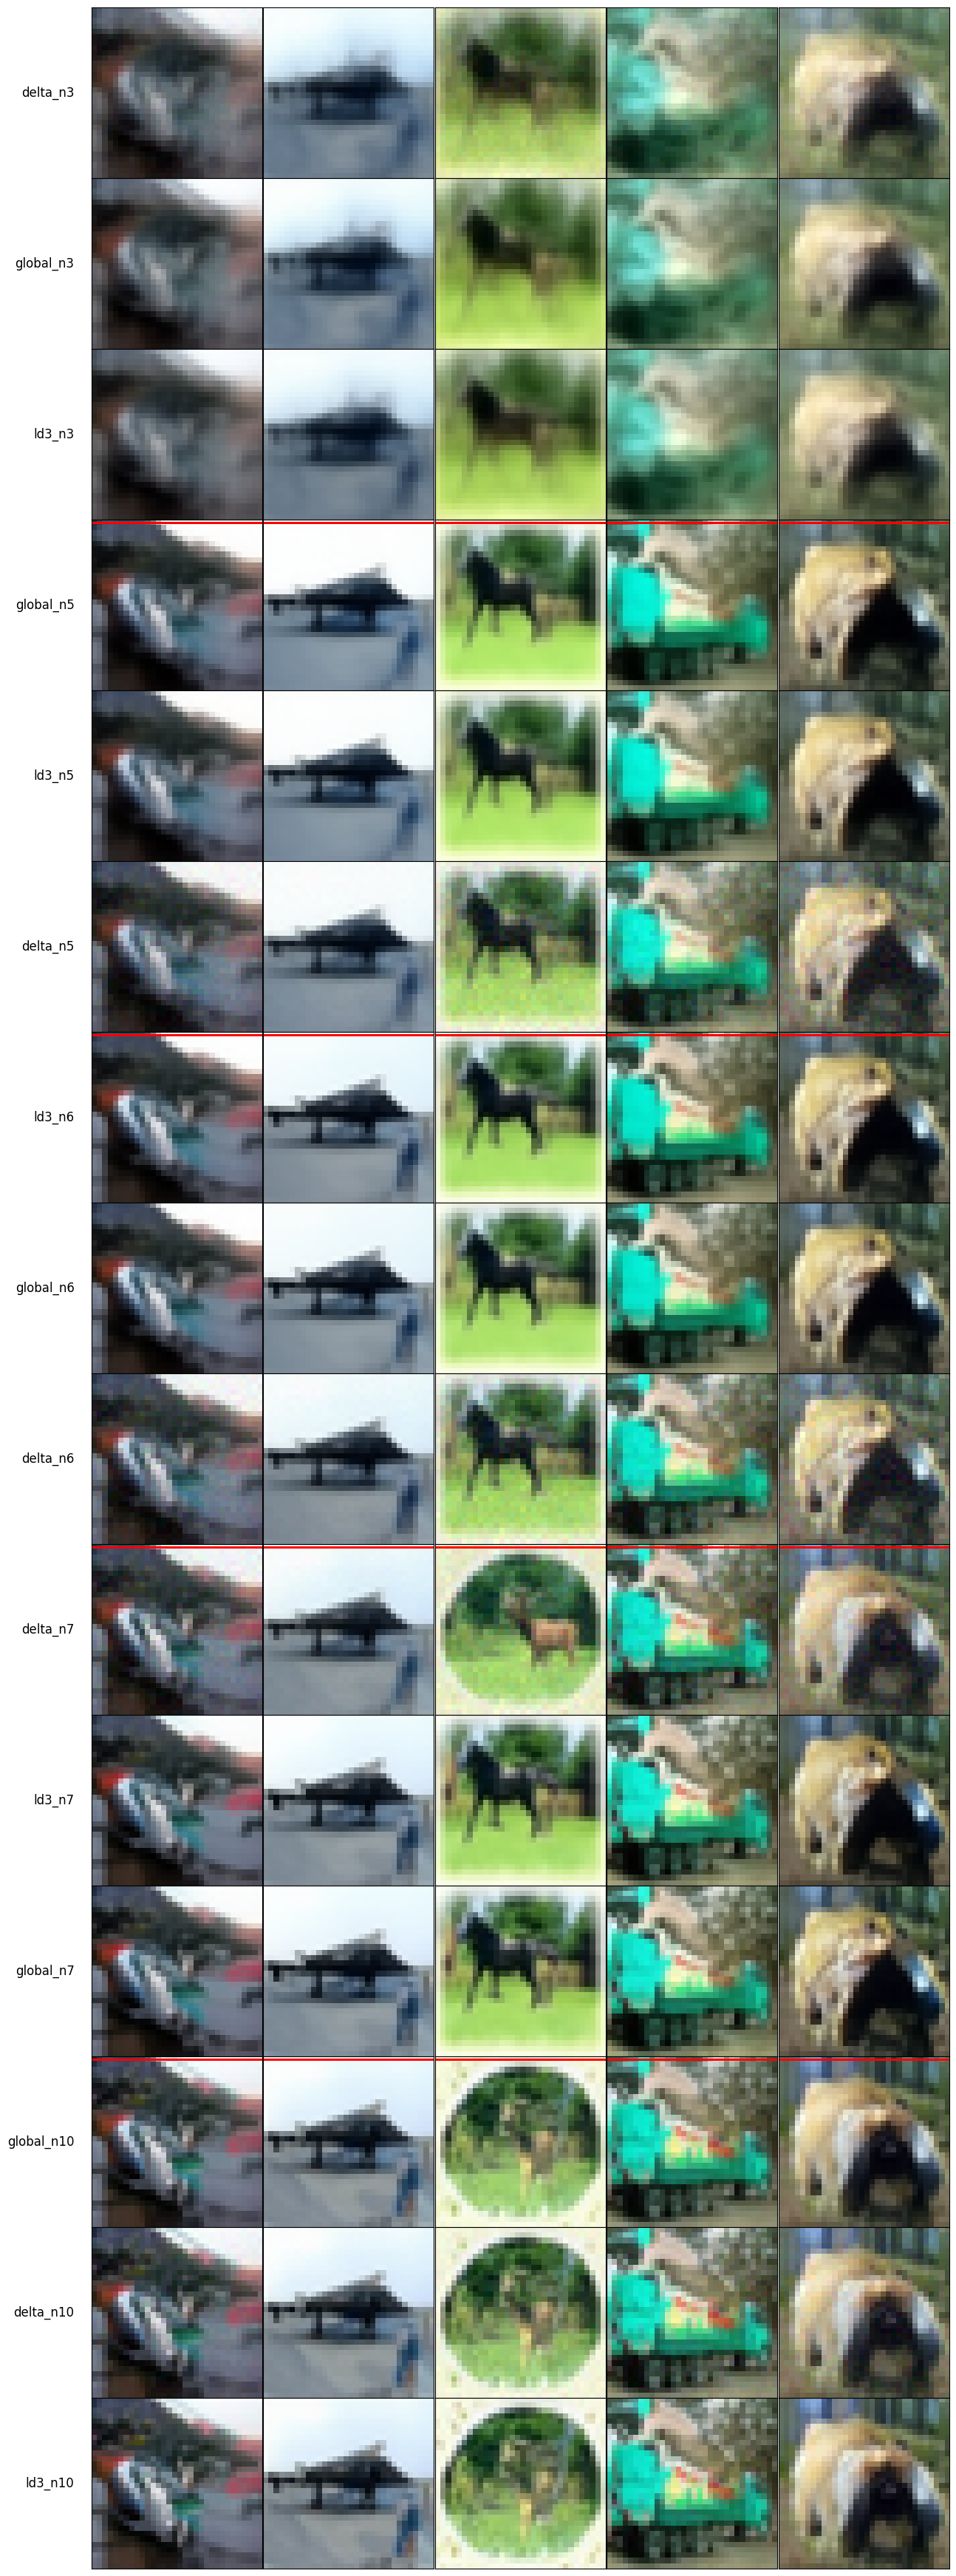

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

base_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated"

# Get the list of subdirectories in the base directory
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Sort subdirectories by nX in the back
subdirs_sorted = sorted(subdirs, key=lambda x: int(x.split('_n')[-1]))

# Create a figure with a grid layout
fig, axes = plt.subplots(len(subdirs_sorted), 5, figsize=(15, len(subdirs_sorted) * 3))
fig.subplots_adjust(wspace=0, hspace=0)  # Remove space between images

# Iterate through each sorted subdirectory
for row, subdir in enumerate(subdirs_sorted):
    subdir_path = os.path.join(base_dir, subdir)
    image_files = sorted([f for f in os.listdir(subdir_path) if f.endswith('.png')])[10:15]  # Get the first 5 images

    # Add subdirectory title to the left axis
    axes[row, 0].set_ylabel(subdir, rotation=0, size='large', labelpad=100, ha='right', va='center')
    axes[row, 0].yaxis.set_label_coords(-0.1, 0.5)  # Adjust label position

    # Plot the first 5 images
    for col, image_file in enumerate(image_files):
        image_path = os.path.join(subdir_path, image_file)
        img = Image.open(image_path)
        axes[row, col].imshow(img)
        axes[row, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Add red horizontal lines every 3 rows
    for r in range(3, len(subdirs_sorted), 3):
        for ax in axes[r, :]:
            ax.axhline(y=0, color='red', linewidth=2)
plt.show()

## Global

In [3]:
#My implementation

n3_params = torch.tensor([0.3125, 0.1682, 0.1343, 0.3851], device='cuda:0')
n3_timestep = torch.tensor([[8.0000e+01, 5.9884e+00, 7.5587e-01, 2.0000e-03]], device='cuda:0')

n5_params = torch.tensor([0.2225, 0.1482, 0.1034, 0.0818, 0.0839, 0.3603], device='cuda:0')
n5_timestep = torch.tensor([[8.0000e+01, 1.0621e+01, 2.5949e+00, 8.5124e-01, 2.7130e-01, 2.0000e-03]],
       device='cuda:0')

n6_params = torch.tensor([0.0437, 0.1651, 0.1108, 0.0790, 0.1370, 0.0390, 0.1000, 0.3254],
       device='cuda:0')
n6_timestep = torch.tensor([[8.0000e+01, 1.2833e+01, 3.7612e+00, 1.5670e+00, 3.4353e-01, 2.2291e-01,
         7.3629e-02, 2.0000e-03]], device='cuda:0')

n7_params = torch.tensor([0.1246, 0.1541, 0.1057, 0.0844, 0.0897, 0.0760, 0.3655],
       device='cuda:0')
n7_timestep = torch.tensor([[8.0000e+01, 1.2389e+01, 3.4480e+00, 1.2409e+00, 4.1899e-01, 1.6694e-01,
         2.0000e-03]], device='cuda:0')

n10_params = torch.tensor([0.0994, 0.1309, 0.0971, 0.0447, 0.0592, 0.0616, 0.1001, 0.0391, 0.0728,
        0.0754, 0.2196], device='cuda:0')
n10_timestep =  torch.tensor([[8.0000e+01, 1.7152e+01, 5.4689e+00, 3.2309e+00, 1.6107e+00, 7.8026e-01,
         2.4016e-01, 1.5164e-01, 6.4386e-02, 2.6514e-02, 2.0000e-03]],
       device='cuda:0')

In [4]:
#LD3
# Load timesteps for n6
ld3_n6_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N6-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n6_dict = torch.load(ld3_n6_path, map_location=device)
ld3_n6_timestep = ld3_n6_dict['best_t_steps'][:len(ld3_n6_dict['best_t_steps']) // 2]

# Load timesteps for n3
ld3_n3_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N3-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n3_dict = torch.load(ld3_n3_path, map_location=device)
ld3_n3_timestep = ld3_n3_dict['best_t_steps'][:len(ld3_n3_dict['best_t_steps']) // 2]

# Load timesteps for n5
ld3_n5_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N5-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n5_dict = torch.load(ld3_n5_path, map_location=device)
ld3_n5_timestep = ld3_n5_dict['best_t_steps'][:len(ld3_n5_dict['best_t_steps']) // 2]

# Load timesteps for n7
ld3_n7_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N7-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n7_dict = torch.load(ld3_n7_path, map_location=device)
ld3_n7_timestep = ld3_n7_dict['best_t_steps'][:len(ld3_n7_dict['best_t_steps']) // 2]

# Load timesteps for n10
ld3_n10_path = "/netpool/homes/connor/LD3_main/logs/logs_cifar10/LD3_correctedLatents_N10-val200-train10000-rv11-seed0/best_v2.pt"
ld3_n10_dict = torch.load(ld3_n10_path, map_location=device)
ld3_n10_timestep = ld3_n10_dict['best_t_steps'][:len(ld3_n10_dict['best_t_steps']) // 2]

/tmp/ipykernel_1018408/3391317573.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ld3_n6_dict = torch.load(ld3_n6_path, map_location=device)
/tmp/ipykernel_1018408/33913

### LPIPS

In [ ]:
def evaluate_params(params: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        print(i)
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        
        timestep = dis_model.convert(params.unsqueeze(0))
        print(timestep)

        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep[0],
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)


for name, params in zip(["n3", "n5", "n6", "n7", "n10"], [n3_params, n5_params,n6_params, n7_params, n10_params]):
    print(f"Loss for {name}: {evaluate_params(params)}")

Time taken:  21.534754753112793  
Loss for n3: 0.27483632415533066  
Time taken:  35.639776945114136  
Loss for n5: 0.14499929174780846  
Time taken:  49.86462879180908  
Loss for n6: 0.08154943212866783  
Time taken:  42.588207721710205  
Loss for n7: 0.11239975690841675  
Time taken:  70.93965196609497  
Loss for n10: 0.027583551593124866  

In [5]:
def evaluate_timestep(timestep: torch.tensor) -> float:    
    start_time = time.time()
    loss_list = []
    for i,batch in enumerate(trainer.valid_only_loader):
        if i*len(batch[0]) < 200: #skip the first 200 to just test on unseen data
            continue
        img, latent, _ = batch
        latent = latent.to(device)
        img = img.to(device)
        
        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep,
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean().item() 
        loss_list.append(loss)
    print("Time taken: ", time.time() - start_time)
    return np.mean(loss_list)




for name, timestep in zip(["n3", "n5", "n6", "n7", "n10"], [ld3_n3_timestep, ld3_n5_timestep, ld3_n6_timestep, ld3_n7_timestep, ld3_n10_timestep]):
    print(f"Loss for {name}: {evaluate_timestep(timestep)}")

Time taken:  8.304322481155396
Loss for n3: 0.2787010371685028
Time taken:  12.00994610786438
Loss for n5: 0.1452961415052414
Time taken:  14.24762487411499
Loss for n6: 0.11326901987195015
Time taken:  16.460753917694092
Loss for n7: 0.08341463096439838
Time taken:  23.243257999420166
Loss for n10: 0.03247475391253829


Time taken:  7.843273401260376  
Loss for n3: 0.2787010371685028  
Time taken:  12.100373268127441  
Loss for n5: 0.1452961415052414  
Time taken:  14.393749952316284   
Loss for n6: 0.11326901987195015  
Time taken:  16.84900426864624  
Loss for n7: 0.08341463096439838  
Time taken:  23.266944408416748  
Loss for n10: 0.03293218836188316  

### FID

https://github.com/toshas/torch-fidelity

##### Reproduction

In [ ]:
batch_size = 500
number_of_fid_images = 50000
shape = (batch_size, 3, 32, 32)
for name, timestep in zip(["n3", "n5", "n6", "n7", "n10"], [n3_timestep, n5_timestep, n6_timestep, n7_timestep, n10_timestep]):
    generator = torch.Generator(torch.device(device))
    timestep = timestep[0]
    generated_images = []
    with torch.no_grad():
        for i in tqdm(range(number_of_fid_images // batch_size), desc=f"Generating Images for {name}"):
            latent = torch.randn(shape, device=torch.device(device), generator=generator)
            x_next = trainer.noise_schedule.prior_transformation(latent)
            x_next = trainer.solver.sample_simple(
                model_fn=trainer.net,
                x=x_next,
                timesteps=timestep,
                order=trainer.order,
                NFEs=trainer.steps,
                **trainer.solver_extra_params,
            )
            x_next = trainer.decoding_fn(x_next)
            generated_images.append(x_next)

        generated_images = torch.cat(generated_images, dim=0)
        save_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated"
        dir_name = f"global_{name}"
        dir_path = os.path.join(save_path, dir_name)
        os.makedirs(dir_path, exist_ok=True)
        for i, img in enumerate(generated_images):
            save_image(img, os.path.join(dir_path, f"{i}.png"), normalize=True)
    torch.cuda.empty_cache()

Generating Images for n5:  60%|██████    | 60/100 [06:41<04:28,  6.71s/it]

#### LD3

In [ ]:
for name, timestep in zip(["n3", "n5", "n6", "n7", "n10"], [ld3_n3_timestep, ld3_n5_timestep, ld3_n6_timestep, ld3_n7_timestep, ld3_n10_timestep]):
    generator = torch.Generator(torch.device(device))
    timestep = timestep[0]
    generated_images = []
    with torch.no_grad():
        for i in tqdm(range(number_of_fid_images // batch_size), desc=f"Generating Images for {name}"):
            latent = torch.randn(shape, device=torch.device(device), generator=generator)
            x_next = trainer.noise_schedule.prior_transformation(latent)
            x_next = trainer.solver.sample_simple(
                model_fn=trainer.net,
                x=x_next,
                timesteps=timestep,
                order=trainer.order,
                NFEs=trainer.steps,
                **trainer.solver_extra_params,
            )
            x_next = trainer.decoding_fn(x_next)
            generated_images.append(x_next)

        generated_images = torch.cat(generated_images, dim=0)
        save_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-generated"
        dir_name = f"global_{name}"
        dir_path = os.path.join(save_path, dir_name)
        os.makedirs(dir_path, exist_ok=True)
        for i, img in enumerate(generated_images):
            save_image(img, os.path.join(dir_path, f"{i}.png"), normalize=True)
    torch.cuda.empty_cache()

## Single Shot


## Recursive Delta Prediction

## Archive

In [ ]:
fid_ref_path = "/netpool/homes/connor/DiffusionModels/LD3_connor/fid-refs/cifar10-32x32.npz"
fid_ref_data = np.load(fid_ref_path)
mu_real = fid_ref_data['mu']
sigma_real = fid_ref_data['sigma']

In [ ]:
fid = FrechetInceptionDistance(feature=2048).to(device)
generated_images = generated_images.to(dtype=torch.uint8)

In [ ]:
fid_batch_size = 100
for i in tqdm(range(0, number_of_fid_images, fid_batch_size), desc="Calculating FID"):
    batch = generated_images[i:i + fid_batch_size]
    fid.update(batch, real=False)
torch.cuda.empty_cache()
# Compute FID statistics

# Calculate FID
fid_value = fid.compute_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
print(f"FID: {fid_value}")
